In [2]:
import os
import pandas as pd
import numpy as np
import random
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pandas import Series
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
random.seed(0)

In [3]:
os.listdir('.')

['.DS_Store',
 '.ipynb_checkpoints',
 'ARIMA.ipynb',
 'data',
 'ETFs.ipynb',
 'Forecast LSTM.ipynb']

In [8]:
os.chdir('./package/data/nasdaq_etfs/')

In [9]:
nasdaq_files = [file for file in os.listdir('.')]

In [8]:
nasdaq_data = []
for filename in nasdaq_files:
    df = pd.read_csv(filename, sep=',')
    label, _, _ = filename.split(sep='.')
    df['Label'] = filename
    df['Date'] = pd.to_datetime(df['Date'])
    nasdaq_data.append(df)

In [10]:
os.chdir('../nyse_etfs/')

In [61]:
nyse_files = [file for file in os.listdir('.')]
nyse_data = []
for filename in nyse_files:
    df = pd.read_csv(filename, sep=',')
    label, _, _ = filename.split(sep='.')
    df['Label'] = filename
    df['Date'] = pd.to_datetime(df['Date'])
    nyse_data.append(df)

In [19]:
# counter = 0
# for i in nyse_data:
#     print(counter)
#     print (set(i['Label']))
#     counter +=1

In [62]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] )
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] )
    d = d.drop(d.index[:(period-1)])
    rs = Series.ewm(u, com=period-1, adjust=False).mean() / \
    Series.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

In [105]:
# PREPROCESSING AND DATA SELECTION
def produce_data():
    indices = [961, 573, 1102, 1091, 228, 1070, 513, 1106, 6, 530]
    starter = [nyse_data[i] for i in indices]
    starter = [i.set_index('Date') for i in starter]
    for i in range(0,len(starter)):
        starter[i]['RSI'] = RSI(starter[i]['Close'], 14)
        starter[i]['Clf_Target'] = (np.sign(-starter[i]['Close'].diff(periods=-1))+1)/2
        starter[i]['Reg_Target'] = -starter[i]['Close'].diff(periods=-1)
    return starter

In [116]:
def add_past(etf_list, window):
    for i in range(len(etf_list)):
        for n in range(1,window+1):
            etf_list[i]['{}day_change'.format(n)] = -etf_list[i]['Close'].diff(periods=n)
    return etf_list

In [133]:
def add_moving_avgs(etf_list):
    for i in range(len(etf_list)):
        etf_list[i]['ewma26'] = etf_list[i]['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
        etf_list[i]['ewma12'] = etf_list[i]['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
        etf_list[i]['MACD'] = (etf_list[i]['ewma12'] - etf_list[i]['ewma26'])
    return etf_list

In [122]:
def save_metrics(y_true, y_pred, ticker):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    return {'!Ticker': ticker, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'ROC AUC': roc}

In [142]:
def plant_forests(df_list):
    results = []
    for i in range(len(df_list)):
        ticker = df_list[i]['Label'].iloc[0]
        X = df_list[i][15:-1].reset_index().drop(columns=['Label','OpenInt','Date','Clf_Target','Reg_Target'])
        y = np.array(df_list[i][15:-1]['Clf_Target'].reset_index().drop(columns='Date')).ravel().astype('int')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
        clf = RandomForestClassifier(n_estimators=100, max_depth=5)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results.append(save_metrics(y_test, y_pred, ticker))
    return results

In [138]:
starter = produce_data()
starter = add_past(starter, 14)
starter = add_moving_avgs(starter)
results = plant_forests(starter)
print ('Mean Accuracy: {}'.format(np.mean([i['Accuracy'] for i in results])))
print ('Mean Precision: {}'.format(np.mean([i['Precision'] for i in results])))
print ('Mean ROC AUC: {}'.format(np.mean([i['ROC AUC'] for i in results])))

Mean Accuracy: 0.5242040252163629
Mean Precision: 0.534068510250697
Mean ROC AUC: 0.5020908708760303


In [141]:
starter[8]

,Open,High,Low,Close,Volume,OpenInt,Label,RSI,Clf_Target,Reg_Target,ewma26,ewma12,MACD
Date,,,,,,,,,,,,,
2005-02-25,86.493,86.516,86.295,86.516,78933,0,agg.us.txt,NaN,0.0,-0.229,86.516000,86.516000,0.000000
2005-02-28,86.516,86.534,86.163,86.287,425148,0,agg.us.txt,NaN,0.0,-0.302,86.397096,86.391958,-0.005138
2005-03-01,85.846,86.050,85.846,85.985,147700,0,agg.us.txt,NaN,0.0,-0.111,86.249034,86.233122,-0.015912
2005-03-02,85.779,86.016,85.779,85.874,202052,0,agg.us.txt,NaN,1.0,0.069,86.144191,86.119761,-0.024429
2005-03-03,86.060,86.069,85.732,85.943,142621,0,agg.us.txt,NaN,1.0,0.246,86.097534,86.071736,-0.025798
2005-03-04,86.146,86.287,86.016,86.189,691835,0,agg.us.txt,NaN,1.0,0.022,86.115854,86.100237,-0.015616
2005-03-07,86.230,86.337,86.033,86.211,239874,0,agg.us.txt,NaN,0.0,-0.185,86.132775,86.124954,-0.007821
2005-03-08,86.016,86.069,85.900,86.026,114021,0,agg.us.txt,NaN,0.0,-0.525,86.115571,86.104304,-0.011267
2005-03-09,85.823,85.846,85.426,85.501,130686,0,agg.us.txt,NaN,0.0,-0.102,86.024478,85.984949,-0.039529


In [137]:
results

[{'!Ticker': 'spy.us.txt',
  'Accuracy': 0.5245901639344263,
  'F1': 0.6419753086419753,
  'Precision': 0.5348101265822784,
  'ROC AUC': 0.5062638878246878},
 {'!Ticker': 'ivv.us.txt',
  'Accuracy': 0.5561160151324086,
  'F1': 0.6828828828828829,
  'Precision': 0.5573529411764706,
  'ROC AUC': 0.5260971234544173},
 {'!Ticker': 'vti.us.txt',
  'Accuracy': 0.5472887767969735,
  'F1': 0.6928999144568007,
  'Precision': 0.5428954423592494,
  'ROC AUC': 0.5179125934445084},
 {'!Ticker': 'voo.us.txt',
  'Accuracy': 0.5315315315315315,
  'F1': 0.6474576271186441,
  'Precision': 0.5584795321637427,
  'ROC AUC': 0.49987656352863724},
 {'!Ticker': 'efa.us.txt',
  'Accuracy': 0.5006305170239597,
  'F1': 0.6125244618395304,
  'Precision': 0.5122749590834698,
  'ROC AUC': 0.49072623278684346},
 {'!Ticker': 'vea.us.txt',
  'Accuracy': 0.4781931464174455,
  'F1': 0.6063454759106933,
  'Precision': 0.48405253283302063,
  'ROC AUC': 0.4812776613091079},
 {'!Ticker': 'iefa.us.txt',
  'Accuracy': 0.48387

In [72]:
X = starter[0][15:-14].reset_index().drop(columns=['Label','OpenInt','Date','Clf_Target','Reg_Target'])
y = np.array(starter[0][15:-14]['Clf_Target'].reset_index().drop(columns='Date')).ravel().astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

In [210]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5)

In [199]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [200]:
y_pred = clf.predict(X_test)

In [201]:
def clf_metrics(y_true, y_pred):
    print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {}'.format(precision_score(y_true, y_pred)))
    print('F1 Score: {}'.format(f1))
    print('ROC AUC: {}'.format(roc_auc_score(y_true, y_pred)))
    return {'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'ROC AUC': roc}

In [204]:
clf_metrics(y_test, y_pred)

Accuracy: 0.5219573400250941
Precision: 0.569327731092437
ROC AUC: 0.5102748481943113


array([[145, 205],
       [176, 271]])

In [26]:
test = data[0].set_index('Date')
test = test.drop(columns = 'OpenInt')

In [35]:
test['Change'] = test['Close']-test['Open']
test['Pct Change'] = test['Change']/test['Open']

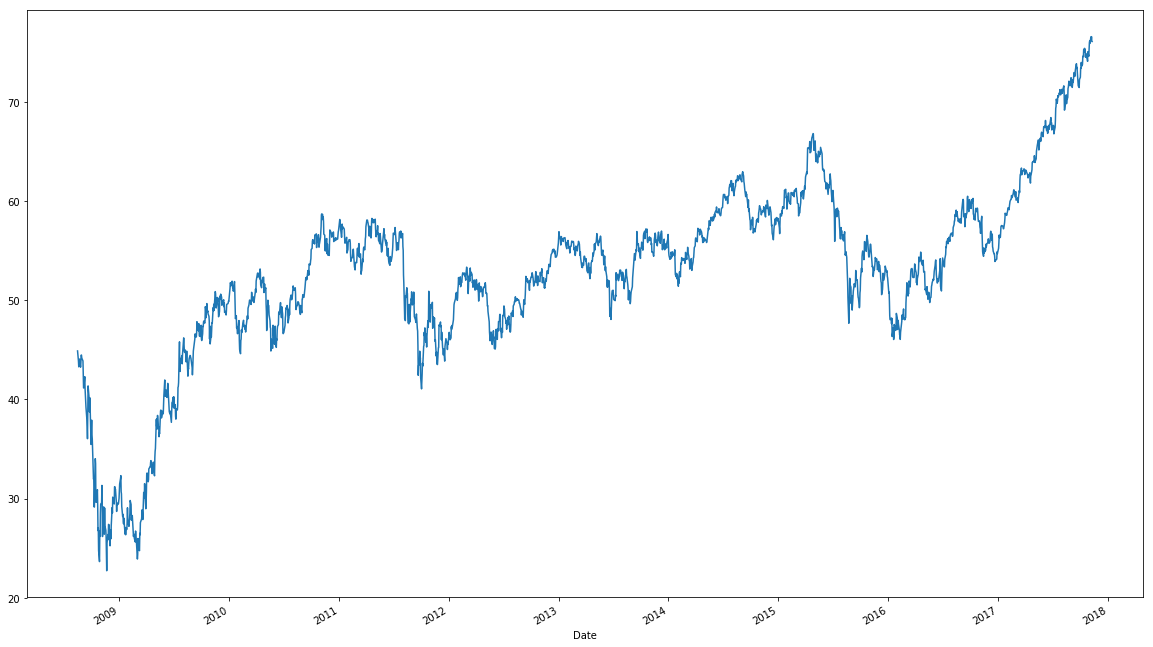

In [70]:
test['Close'].plot(figsize=(20,12))

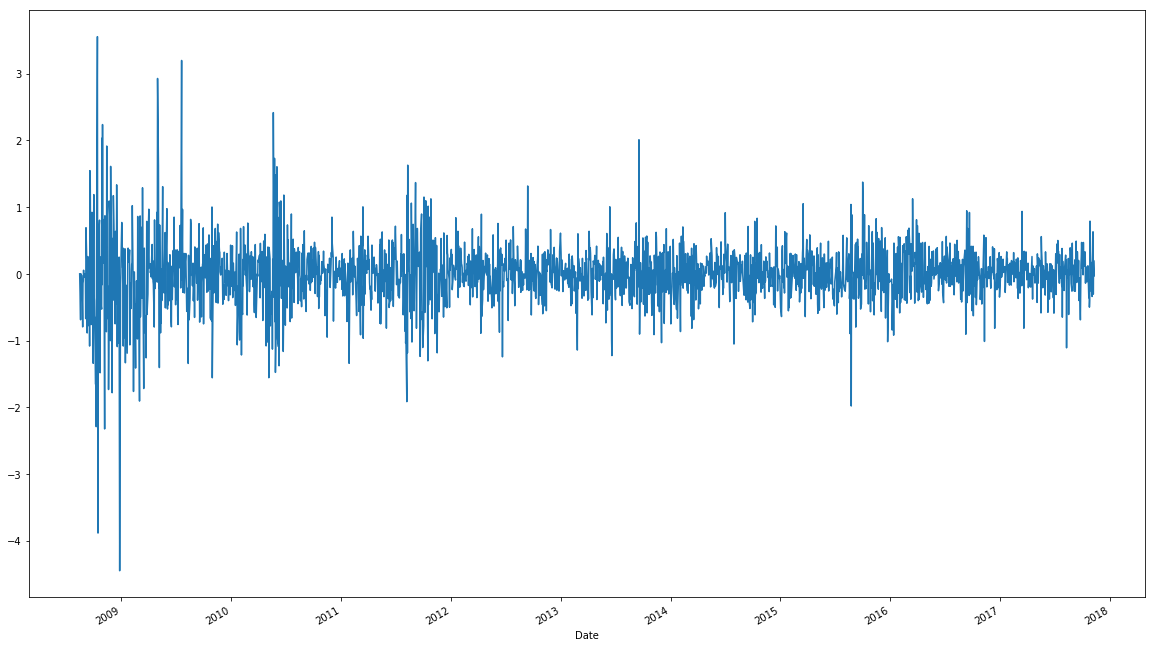

In [34]:
test['Change'].plot(figsize=(20,12))